In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

np.random.seed(42)
torch.cuda.set_device(1)

from annoy import AnnoyIndex

import urllib

In [2]:
import requests

import psycopg2
import sys, os
import config as creds

In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


## Inventory Table Connection

In [4]:
def connect():
    # Set up a connection to the postgres server.
    conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
    +" password="+ creds.PGPASSWORD
    conn=psycopg2.connect(conn_string)
    print("Connected!")

    # Create a cursor object
    cursor = conn.cursor()
    return conn, cursor

In [5]:
def disconnect(conn, cursor):
    cursor.close()
    conn.close()
    print("Connection Closed!")
    

## Creating ANN Index

In [23]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [67]:
#loads cnn pkl file
def load_cnn(pkl_filename):
    learn = load_learner(path='Img/', file=pkl_filename)
    return learn

# returns the embeddings for a single image,
# from a single given CNN's last FC layer
def get_embeddings_for_image(cnn, img_path):
    hook = hook_output(cnn.model[-1][-3])
    cnn.predict(open_image(img_path))
    hook.remove()
    return hook.stored.cpu()[0]

# returns the concatenated embeddings for a single image,
# from the given list of CNNs' last FC layer
def get_combined_embeddings_for_image(cnns, img_path):
    embeddings = []
    for cnn in cnns:
        embeddings.append(get_embeddings_for_image(cnn, img_path))

    return np.concatenate(embeddings)

# returns the embeddings for multiple image, from
# a single given CNN's last FC layer
def get_embeddings_for_images(cnn, img_paths):
    sf = SaveFeatures(cnn.model[-1][-3])
    cnn.data.add_test(img_paths)
    cnn.get_preds(DatasetType.Test)
    sf.remove()
    return sf.features

# returns the embeddings for multiple image, from
# a list of given CNNs' last FC layer
def get_combined_embeddings_for_images(cnns, img_paths):
    embeddings = []
    for cnn in cnns:
        embeddings.append(get_embeddings_for_images(cnn, img_paths))

    return np.concatenate(embeddings, axis=1)

# creates an ANN index from the given list of embeddings
def create_ann_index(embeddings, dim = 512, trees = 10):
    ann_index = AnnoyIndex(dim)
    for i in range(len(embeddings)):
        ann_index.add_item(i, embeddings[i])
    ann_index.build(trees)
    return ann_index

# queries the given vector against the given ANN index
def query_ann_index(ann_index, embeddings, n = 5):
    nns = ann_index.get_nns_by_vector(embeddings, n=n, include_distances=True)
    conn, cursor = connect()
    cursor.execute("""SELECT index, image 
                    FROM inventory 
                    WHERE index IN (%s,%s,%s,%s,%s) 
                    ORDER BY array_position(array[%s,%s,%s,%s,%s],inventory.index)""",
                  (nns[0][0],nns[0][1],nns[0][2],nns[0][3],nns[0][4],nns[0][0],nns[0][1],nns[0][2],nns[0][3],nns[0][4]))
    part_paths = cursor.fetchall()
    img_paths = ['https://pc-ap.rtrcdn.com/'+row[1] for row in part_paths]
    return img_paths, nns[1]

# displays the list of given image paths
def display_images(img_paths, sim_scores):
    for i, img_path in enumerate(img_paths):
        print(sim_scores[i])
        show_image(open_image(urllib.request.urlopen(img_path)))
        
        
# Get and display recs 
def get_recs(img_path, cnns, ann_index, n=5):
    embedding = get_combined_embeddings_for_image(cnns, img_path)
    img_paths, sim_scores = query_ann_index(ann_index, embedding, n)
    return display_images(img_paths, sim_scores)
#     return img_paths, sim_scores
    

In [25]:
cat_learner = load_cnn('cat-rn50-size150-fr4-unfr2-fr4-unfr4.pkl')

In [26]:
texture_learner = load_cnn('texture-resnet50-size150-fr12-unfr4.pkl')

In [27]:
fabric_learner = load_cnn('fabric-resnet50-size150-fr5-unfr4.pkl')

In [28]:
parts_learner = load_cnn('parts-resnet50-size150-fr5-unfr4.pkl')

In [29]:
shape_learner = load_cnn('shape-resnet50-size150-fr5-unfr4.pkl')

In [30]:
all_cnns = [cat_learner, texture_learner, fabric_learner, parts_learner, shape_learner]

def build_inventory_ann_index(img_paths):
    print("Inventory size: {} images".format(len(img_paths)))
    
    combined_embeddings = get_combined_embeddings_for_images(all_cnns, img_paths)
    print("Got {} embeddings".format(len(combined_embeddings)))
    
    ann_index = create_ann_index(combined_embeddings, 512 * len(all_cnns), 10)
    print("ANN index has {} items".format(ann_index.get_n_items()))
    
    return ann_index


In [31]:
conn, cursor = connect()

cursor.execute("SELECT image FROM inventory ORDER BY index")

images = cursor.fetchall()

disconnect(conn, cursor)

Connected!


In [57]:
def dl_images(urls):
    img_paths = []
    for row in urls:
        img_paths.append(urllib.request.urlretrieve('https://pc-ap.rtrcdn.com/'+ row[0])[0])
        
        if len(img_paths)%1000 == 0:
            print("Num images downloaded:", len(img_paths))
        
    return img_paths


In [58]:
rtr_images = dl_images(images)

Num images downloaded: 1000
Num images downloaded: 2000
Num images downloaded: 3000
Num images downloaded: 4000
Num images downloaded: 5000
Num images downloaded: 6000
Num images downloaded: 7000
Num images downloaded: 8000
Num images downloaded: 9000
Num images downloaded: 10000
Num images downloaded: 11000
Num images downloaded: 12000
Num images downloaded: 13000


In [62]:
# build a RTR inventory index
rtr_inventory = build_inventory_ann_index(rtr_images)
rtr_inventory.save('rtr_inventory_5cnn_DB.ann')

Got 13656 embeddings
ANN index has 13656 items


True

In [ ]:
with open('rtr_images.pkl', 'wb') as f:
    pickle.dump(rtr_images, f)

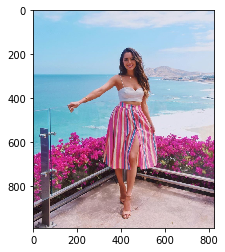

In [69]:
from matplotlib import image

# load the image
data = image.imread('pink.jpg')

plt.imshow(data)
plt.show()

Connected!
0.7932114601135254
0.8037494421005249
0.8190317153930664
0.8400436043739319
0.8493857383728027


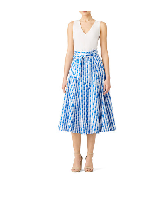

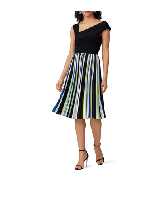

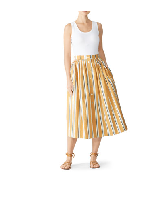

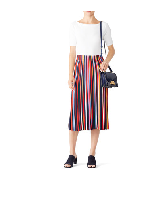

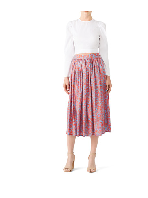

In [68]:
get_recs('pink.jpg',all_cnns, rtr_inventory, 5)